# Predicting treatment outcome in breast cancer patients

The data contained in `breast_cancer_data.tsv` describes breast cancer tumors in patients using 18 variables, all measured before treatment:

- `Age`: age (in years)
- `Menopausal status`: 0=pre-menopause, 1=post-menopause
- `T stage`: classification (0-4) of the tumor according to [the TNM classification](https://en.wikipedia.org/wiki/TNM_staging_system)
- `N stage`: classification (0-2) of lymph node involvement according to [the TNM classification](https://en.wikipedia.org/wiki/TNM_staging_system)
- `ER Status`: whether the tumor has estrogen receptors (0=negative, 1=positive)
- `PR Status`: whether the tumor has progesterone receptors (0=negative, 1=positive)
- `Ki67 25%`: whether the proliferation marker Ki67 is overexpressed (0=negative, 1=positive)
- `TILs 30%`: whether lymphocytic infiltration is high (0=negative, 1=positive)
- `Breast Density`: breast density according to [the BI-RADS classification](https://en.wikipedia.org/wiki/BI-RADS) (0=A, 1=B, 2=C, 3=D)
- `US LN Cortex`: ultrasound (_US_) evaluation of the lymph node (_LN_) cortex capsule (0=Thin, 1=Thickened)
- `Intratumoral high SI on T2`: evaluation of signal intensity (_high SI = high signal intensity_) on [T2*-weighted MRI](https://en.wikipedia.org/wiki/T2*-weighted_imaging) (0=absent, 1=present)
- `Peritumoral Edema`: peritumoral edema (0=absent, 1=present)
- `Prepectoral Edema`: prepectoral edema (0=absent, 1=present)
- `Subcutaneous Edema`: subcutaneous edema (0=absent, 1=present)
- `Multifocality`: multifocality (presence of additional malignancy sites) (0=absent, 1=present)
- `Maximal MR Size`: size (estimated on MRI, based on its largest axis) of the tumor mass
- `Index Lesion MR Size`: size (estimated on MRI, based on its largest axis) of the initial lesion
- `Size of Largest LN metastasis (mm)`: size of the largest lymph node metastasis

These variables belong to 3 different categories:
- Clinical variables: `Age`, `BMI`, `Menopausal status`, `T stage`, `N stage`
- Histological variables: `ER Status`, `PR Status`, `Ki67 25%`, `TILs 30%`
- Imaging variables: `Breast Density`, `US LN Cortex`, `Intratumoral high SI on T2`, `Peritumoral Edema`, `Prepectoral Edema`, `Subcutaneous Edema`, `Multifocality`, `Maximal MR Size`, `Index Lesion MR Size`, `Size of Largest LN metastasis (mm)`

The file `breast_cancer_pcr.tsv` contains the variable (label) `pCR Status` (_pCR = pathological complete response_), which indicates whether or not chemotherapy successfully eliminated the tumor.

The goal of this study is to evaluate whether the proposed variables can predict the `pCR Status` response.


## Usefull Libraries

In [6]:
import numpy as np
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


## Loading Datas

In [8]:
df_data = pd.read_csv("breast_cancer_data.tsv", sep="\t")
X = np.array(df_data)

df_pcr = pd.read_csv("breast_cancer_pcr.tsv", sep="\t")
y = np.array(df_pcr)

## Preprocessing of the datas

In [9]:
df_data.head()

,Age,Menopausal Status,T Stage,N Stage,ER Status,PR Status,Ki67 25%,TILs 30%,Breast Density,US LN Cortex,Intratumoral high SI on T2,Peritumoral Edema,Prepectoral Edema,Subcutaneous Edema,Multifocality,Maximal MR Size,Index Lesion MR Size,Size of Largest LN metastasis (mm)
0,70,1,0,0,0,0,1,0,2,0,0,1,0,0,0,54,25,0
1,43,0,2,1,1,1,1,1,1,0,0,0,0,0,0,30,30,6
2,33,0,1,1,0,0,1,1,1,1,0,1,1,0,0,47,47,0
3,48,0,1,0,1,1,0,0,2,0,0,1,0,0,0,45,45,0
4,49,0,1,0,1,1,0,0,1,0,0,0,1,0,0,24,24,0


In [15]:
print(f"X's shape : {X.shape}. y's shape : {y.shape}")

X's shape : (243, 18). y's shape : (243, 1)


On observe que, comme dans beaucoup de cas dans le domaine médicale, l'ensemble des données disponibles est restreint: on ne dispose que de 243 vecteurs.

De plus, la base de données nous fournis beaucoup de features (18). Nous nous sommes alors interrogés sur la nécessités de toutes ces dernières qui peuvent parfois être difficile à obtenir. Nous reviendrons dessus plus tard.

Une question que nous nous sommes ensuite posé a été la méthode de scoring de notre algorithme.

Plutôt que de d'évaluer notre modèle avec une accuracy nous avons choisis de **maximiser les True Negative** (càd d'être sur que la chimiothérapie ne va pas marcher). En effet, la médecine a tendance à préférer trop soigner que pas assez, esayer des soins quitte à ce qu'ils ne fonctionnent pas.

Comme nous allons utiliser la metrics *roc_auc_score* de *scikit learn*, qui maximise l'air sous la courbe *True_positive_rate = f(False_positive_rate)*, nous échangeons les labels afin que les positifs (labels = 1) correspondent à une chimio qui n'a pas fonctionnée et le label 0 à une chimiothérapie qui a fonctionnée. Nous la noterons *y_inv* (pour inversé) afin de ne pas perdre de vu ce changement par la suite.

In [11]:
y ^= 1 #opération XOR pour inverser les valeurs de y, les 0 deviennent des 1 et inversement
y_inv=y

In [12]:
# On divise les données en un ensemble d'apprentissage et un ensemble de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_inv_train, y_inv_test = train_test_split(X, y_inv, test_size=0.2, random_state=42, stratify=y_inv)

Dans la suite, nous allons entrainer différents modèles sur les données brutes, onehot encodées et normalisées. Nous nous occupons de ce prétraitement ici afin de ne plus revenir dessus.

Afin de pouvoir comparer au mieux les modèles entre eux, nous avons pris soins de **garder le même jeu de test** à chaque phase d'évaluation.

In [13]:
from sklearn.preprocessing import OneHotEncoder

X_test_hotencoded = pd.DataFrame(data=X_test, columns=df_data.columns.values)
X_train_hotencoded= pd.DataFrame(data=X_train, columns=df_data.columns.values)

# Liste manuelle des colonnes catégorielles
categorical_columns = ['T Stage', 'N Stage', 'Breast Density']  # Remplacez par vos propres colonnes

# Identifier les colonnes numériques (toutes les autres colonnes)
numerical_columns = [col for col in df_data.columns if col not in categorical_columns]

# Utiliser OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', categories=[[0,1,2,3,4],[0,1,2],[0,1,2,3]])  # `drop='first'` pour éviter la redondance
encoded_datatrain = encoder.fit_transform(X_train_hotencoded[categorical_columns])
encoded_datatest = encoder.fit_transform(X_test_hotencoded[categorical_columns])

# Transformer en DataFrame pour les colonnes encodées
encoded_dftrain = pd.DataFrame(encoded_datatrain, columns=encoder.get_feature_names_out(categorical_columns))
encoded_dftest = pd.DataFrame(encoded_datatest, columns=encoder.get_feature_names_out(categorical_columns))

# Concaténer les colonnes encodées avec les colonnes numériques
X_test_hotencodeddf = pd.concat([X_test_hotencoded.drop(columns=categorical_columns), encoded_dftest], axis=1)
X_train_hotencodeddf = pd.concat([X_train_hotencoded.drop(columns=categorical_columns), encoded_dftrain], axis=1)

X_test_hotencoded = np.array(X_test_hotencodeddf)
X_train_hotencoded = np.array(X_train_hotencodeddf)

In [14]:
from sklearn.preprocessing import StandardScaler

sdt_scaler = StandardScaler()
sdt_scaler.fit(X_train)
X_train_scaled = sdt_scaler.transform(X_train)
X_test_scaled = sdt_scaler.transform(X_test)

sdt_scaler2 = StandardScaler()
sdt_scaler2.fit(X_train_hotencoded)
X_train_hotencoded_scaled = sdt_scaler2.transform(X_train_hotencoded)
X_test_hotencoded_scaled = sdt_scaler2.transform(X_test_hotencoded)

# Visualisation des données

Dans cette partie nous allons visualiser les données afin de constater la présence, ou non, de paternes, cluster ou autres. Cette partie a aussi eu pour but de nous familiariser avec ce dataset.

In [12]:
from sklearn import preprocessing

def center_and_normalise_kernel(K_temp):
    K_temp = preprocessing.KernelCenterer().fit_transform(K_temp)
    nb_item = K_temp.shape[0]
    K_norm = np.zeros((nb_item, nb_item))
    for i in range(nb_item):
        for j in range(i, nb_item):
            K_norm[i, j] = K_temp[i, j] / np.sqrt(K_temp[i, i] * K_temp[j, j])
            K_norm[j, i] = K_norm[i, j]

    return K_norm

Ici, on affiche la matrice de Gram linéaire.


(243, 24)


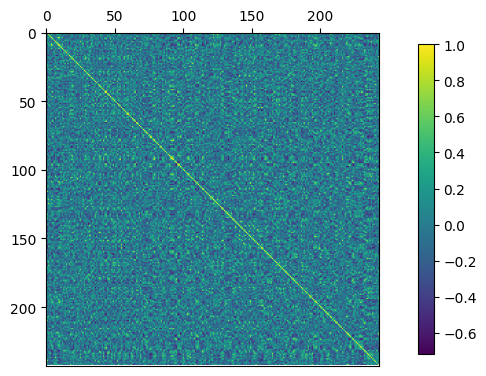

In [13]:
data_end_preprocessing = np.vstack((X_train_hotencoded_scaled, X_test_hotencoded_scaled)) # On observe tous les exemples donc on concatène les data set d'entraînement et de test
print(data_end_preprocessing.shape)
GramMatrix = np.dot(data_end_preprocessing, data_end_preprocessing.T) # Construction de la matrice de Gram
GramMatrix_scaled = center_and_normalise_kernel(GramMatrix) # Valeurs centrées et normalisées de la matrice

# Affichage
# heatmap + color map
fig, ax = plt.subplots(figsize=(5, 5))
plot = ax.imshow(GramMatrix_scaled)
# set axes boundaries
ax.set_xlim([0, data_end_preprocessing.shape[0]]) ; ax.set_ylim([0, data_end_preprocessing.shape[0]])
# flip the y-axis
ax.invert_yaxis() ; ax.xaxis.tick_top()
# plot colorbar to the right
plt.colorbar(plot, pad=0.1, fraction=0.04)

Ici, on affiche la matrice de Gram avec noyau RBF.

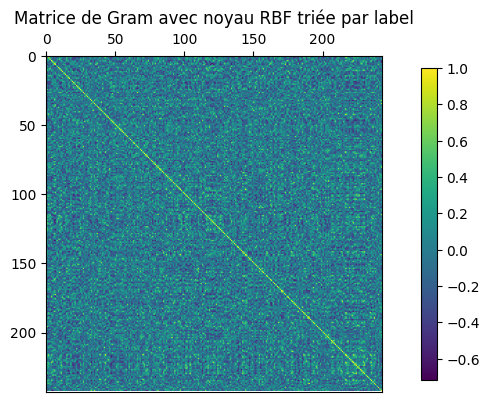

In [14]:
from sklearn.metrics import pairwise
data_with_labels = pd.DataFrame(data_end_preprocessing)
data_with_labels['label'] = y_inv

# Trier les données par label
sorted_data = data_with_labels.sort_values(by='label')

# Extraire les vecteurs triés et les labels triés
sorted_vectors = sorted_data.iloc[:, :-1].values  # Les données triées
sorted_labels = sorted_data['label'].values

# Calcul de la matrice de Gram avec un noyau RBF
GramMatrix = pairwise.rbf_kernel(sorted_vectors, gamma=0.0001)  # Noyau RBF
GramMatrix_scaled = center_and_normalise_kernel(GramMatrix)  # Normalisation de la matrice de Gram

# Étape 3 : Affichage de la heatmap
fig, ax = plt.subplots(figsize=(5, 5))
plot = ax.imshow(GramMatrix_scaled, cmap='viridis')

# set axes boundaries
ax.set_xlim([0, sorted_vectors.shape[0]])
ax.set_ylim([0, sorted_vectors.shape[0]])

# Inverser l'axe Y pour une orientation intuitive
ax.invert_yaxis()
ax.xaxis.tick_top()

# Ajouter une barre de couleur
plt.colorbar(plot, pad=0.1, fraction=0.04)

# Afficher la matrice de Gram
plt.title("Matrice de Gram avec noyau RBF triée par label")
plt.tight_layout()
plt.show()

Maintenant, on réalise l'ACP avec 2 composantes principales.

In [15]:
ydf=pd.DataFrame(y_inv)

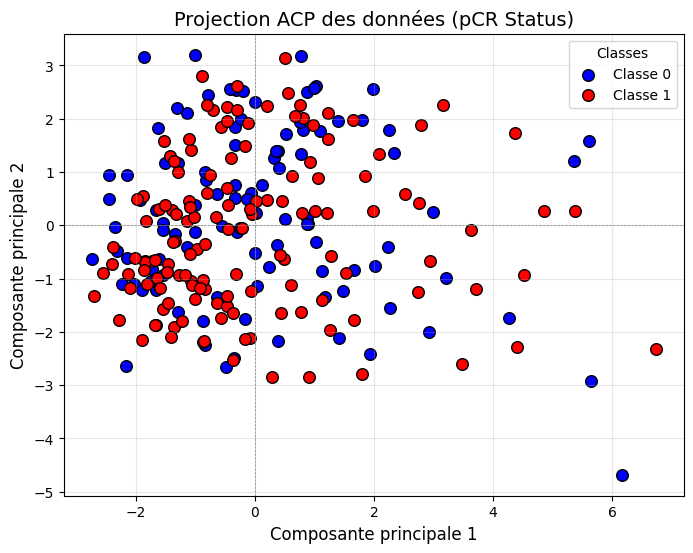

In [16]:
from sklearn.decomposition import PCA

# On extrait les labels et les classes pour l'affichage
labels_pca = df_pcr["pCR Status"]
classes = ydf[0].unique()  # Classes uniques : ici, probablement 0 et 1
colors = ['blue', 'red']  # Ajouter des couleurs en fonction du nombre de classes

# On décrit l'ACP et on projette les données sur les deux principales composantes
pca_2_components = PCA(n_components=2)
data_pca_2 = pca_2_components.fit_transform(data_end_preprocessing)

# Affichage
plt.figure(figsize=(8, 6))

# Boucle pour afficher chaque classe avec une couleur distincte
for label, color in zip(classes, colors):
    plt.scatter(data_pca_2[ydf[0] == label, 0],
                data_pca_2[ydf[0] == label, 1],
                c=color, label=f'Classe {label}', edgecolor='k', s=70)

# Ajouter des lignes pour les axes
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

# Ajouter un titre et des labels
plt.title('Projection ACP des données (pCR Status)', fontsize=14)
plt.xlabel('Composante principale 1', fontsize=12)
plt.ylabel('Composante principale 2', fontsize=12)
plt.legend(title="Classes")
plt.grid(alpha=0.3)

# Afficher le graphique
plt.show()

Maintenant, on réalise l'ACP avec 3 composantes principales

In [17]:
import plotly.express as px # Permet d'avoir un affichage interactif. Si ne marche pas, vérifier qu'on a fait !pip install plotly, from google.colab import output, output.enable_custom_widget_manager()

# Appliquer l'ACP
pca_3_components = PCA(n_components=3)  # Garder les trois premières composantes principales
X_pca = pca_3_components.fit_transform(data_end_preprocessing)

# Création de la visualisation 3D interactive avec plotly
fig = px.scatter_3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    color=ydf[0],  # Couleur par classe
    labels={'x': 'Composante principale 1', 'y': 'Composante principale 2', 'z': 'Composante principale 3'},
    title='Projection ACP en 3 composantes principales'
)

fig.update_layout(legend_title_text="Classes")
fig.show()


Dans cette section, on affiche les corrélations entre les variables du jeu de données.

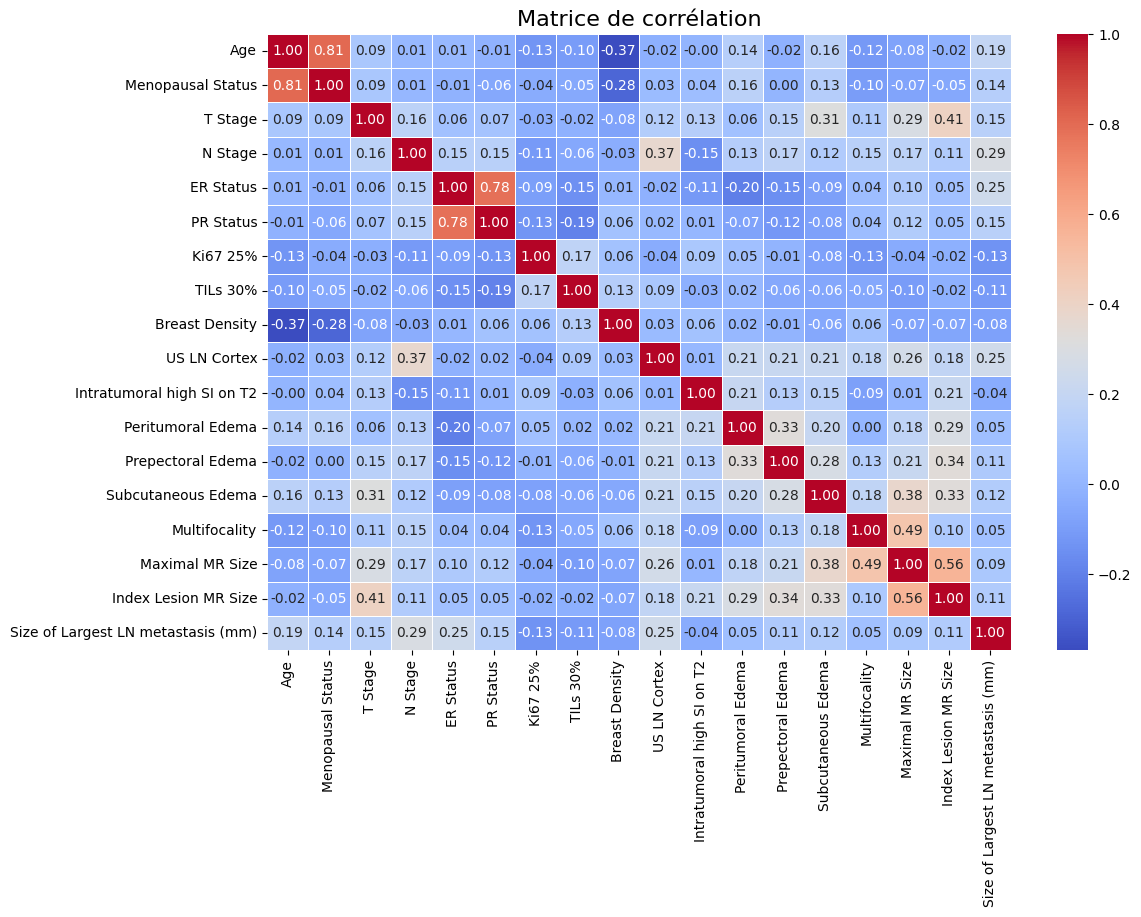

In [18]:
# Heatmap des corrélations
plt.figure(figsize=(12, 8))
corr_matrix = df_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation", fontsize=16)
plt.show()

Dans cette section, on affiche les relations entre les paires de variables du jeu de données.

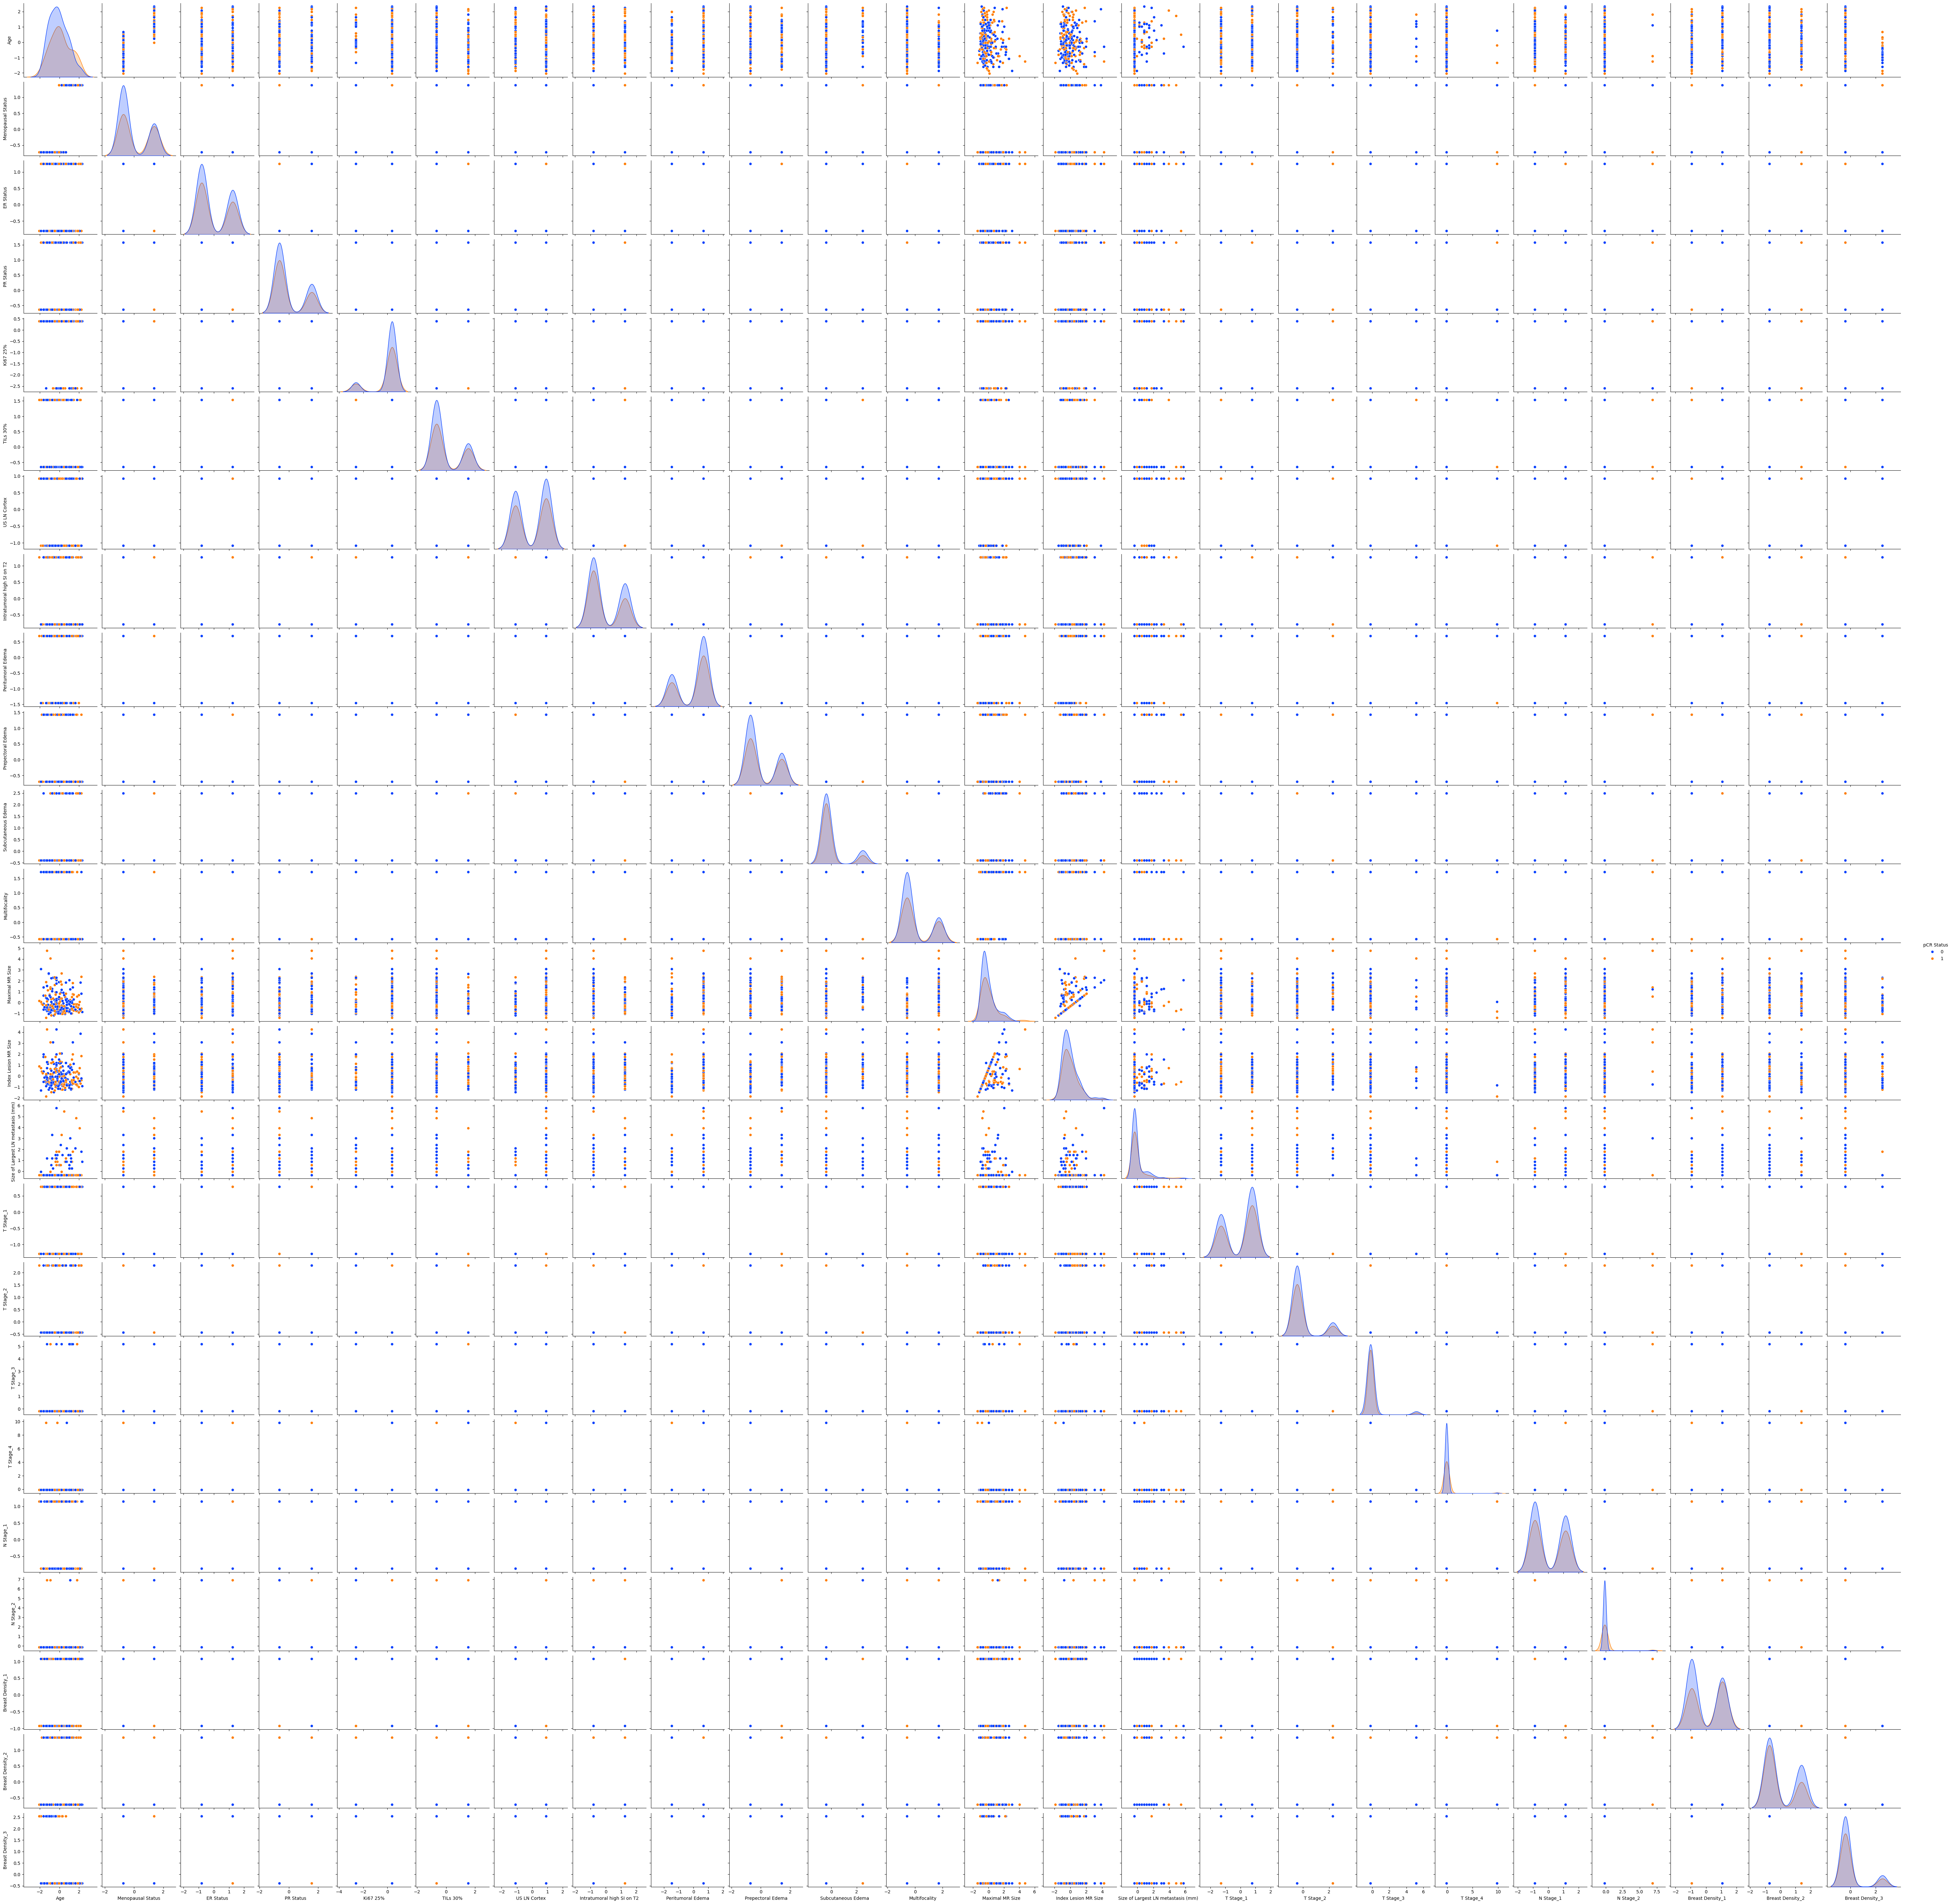

In [19]:
data_end_preprocessing = pd.DataFrame(data_end_preprocessing, columns=X_test_hotencodeddf.columns)
data_end_preprocessing['pCR Status'] = df_pcr['pCR Status']
sns.pairplot(data_end_preprocessing, hue='pCR Status', palette="bright")

# Random Forest

Comme les données comportent un grand nombre de features nous avons choisis de tester le modèle **Random Forest** afin d'avoir un premier aperçu rapide du potentiel des données.

Pour ce faire, nous commençons par le tester directement sur les données d'entraînements initiales.

## 1er essai RF: directement sur les données

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score


In [21]:
#Utilisation d'un grid_search afin de trouver les meilleurs hyperparamètres pour le modèle
param_grid_rf1 = {'n_estimators': [10,50,75,80,100,140,300], 'max_depth': [None, 30,60,100,200], 'min_samples_leaf':[2, 4, 6, 8],  'warm_start': [True,False] }


grid_search_rf1 = GridSearchCV(RandomForestClassifier(
            criterion='gini',
            min_samples_split=2,
            min_samples_leaf=1, min_weight_fraction_leaf=0.0,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            random_state=42, verbose=0,
            class_weight=None,
            ccp_alpha=0.0, max_samples=None),
                               param_grid=param_grid_rf1, cv=5, verbose=0, scoring='roc_auc')

Les paramètres du *gridsearch* ont été choisis après plusieurs itérations de la méthode afin de l'affiner: dans un premier nous avons cherché l'ordre de grandeur du meilleur paramètre avant d'entrer dans le détail de ce dernier.

In [22]:
grid_search_rf1.fit(X_train, y_inv_train.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 30, 60, 100, 200],
                         'min_samples_leaf': [2, 4, 6, 8],
                         'n_estimators': [10, 50, 75, 80, 100, 140, 300],
                         'warm_start': [True, False]},
             scoring='roc_auc')

In [23]:
print(grid_search_rf1.best_params_)

{'max_depth': None, 'min_samples_leaf': 6, 'n_estimators': 80, 'warm_start': True}


In [24]:
print(f"Le meilleur score lors de l'entrainement était: {grid_search_rf1.best_score_}, et le score de test est {grid_search_rf1.score(X_test, y_inv_test.ravel())}")


Le meilleur score lors de l'entrainement était: 0.6898395721925134, et le score de test est 0.7806122448979591


Matrice de confusion sur le jeu d'entrainement


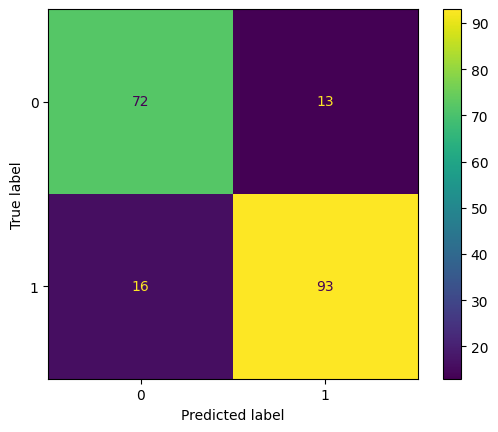

In [25]:
ConfusionMatrixDisplay.from_predictions(y_inv_train, grid_search_rf1.predict(X_train))
print(f"Matrice de confusion sur le jeu d'entrainement")

Matrice de confusion sur le jeu de test


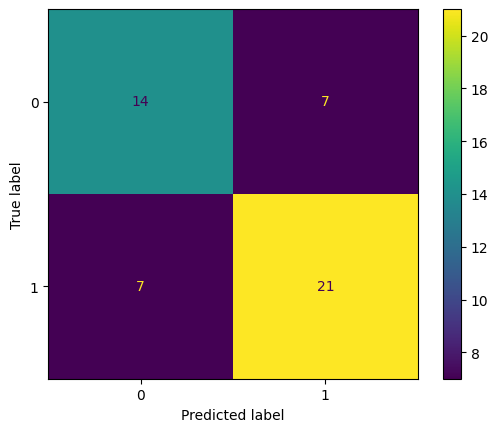

In [26]:
ConfusionMatrixDisplay.from_predictions(y_inv_test, grid_search_rf1.predict(X_test))
print(f"Matrice de confusion sur le jeu de test")


Ce premier modèle est très bon avec un score roc_auc de 78% sur le jeu de test. La matrice de confusion nous montre que le scoring choisi à bien favoriser les True Negative (attention nos labels sont inversés sur la figure; pour lire les True Negatives il faut lire la case (1,1)).

## 2eme essai RF: sur données normalisées

Nous avons ensuite voulu voir si normaliser les données allait amméliorer la performance de notre modèle.

In [27]:
#Utilisation d'un grid_search afin de trouver les meilleurs hyperparamètres pour le modèle

param_grid_rf2 = {'n_estimators': [10,50,75,80,100,140,300], 'max_depth': [None, 30,60,100,200,400,600,800], 'min_samples_leaf':[2, 4, 6, 8],  'warm_start': [True,False] }


grid_search_rf2 = GridSearchCV(RandomForestClassifier(
            criterion='gini',
            min_samples_split=2,
            min_samples_leaf=1, min_weight_fraction_leaf=0.0,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            random_state=42, verbose=0,
            class_weight=None,
            ccp_alpha=0.0, max_samples=None),
                               param_grid=param_grid_rf1, cv=5, verbose=0, scoring='roc_auc')

In [28]:
grid_search_rf2.fit(X_train_scaled, y_inv_train.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 30, 60, 100, 200],
                         'min_samples_leaf': [2, 4, 6, 8],
                         'n_estimators': [10, 50, 75, 80, 100, 140, 300],
                         'warm_start': [True, False]},
             scoring='roc_auc')

In [29]:
print(grid_search_rf2.best_params_)

{'max_depth': None, 'min_samples_leaf': 6, 'n_estimators': 80, 'warm_start': True}


In [30]:
print(f"Le meilleur score lors de l'entrainement était: {grid_search_rf2.best_score_}, et le score de test est {grid_search_rf2.score(X_test_scaled, y_inv_test.ravel())}")


Le meilleur score lors de l'entrainement était: 0.6910873440285205, et le score de test est 0.7806122448979591


Matrice de confusion sur le jeu d'entrainement


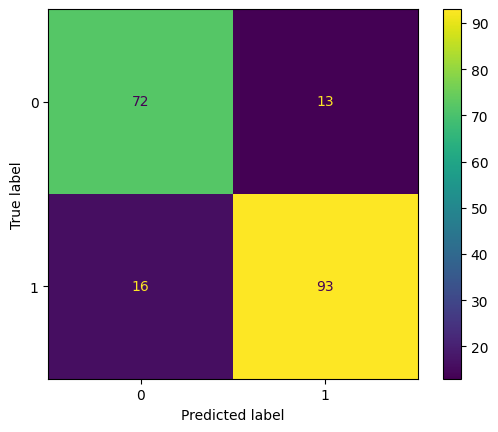

In [31]:
ConfusionMatrixDisplay.from_predictions(y_inv_train, grid_search_rf2.predict(X_train_scaled))
print(f"Matrice de confusion sur le jeu d'entrainement")

Matrice de confusion sur le jeu de test


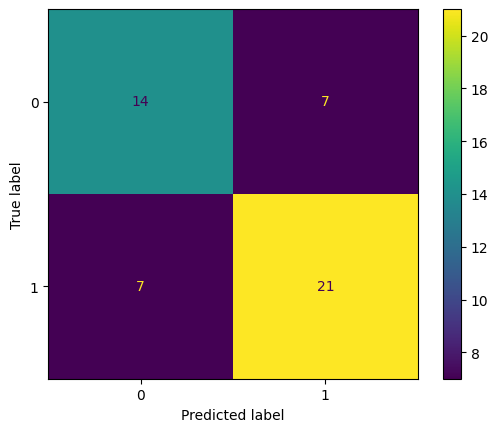

In [32]:
ConfusionMatrixDisplay.from_predictions(y_inv_test, grid_search_rf2.predict(X_test_scaled))
print(f"Matrice de confusion sur le jeu de test")

Ce nouveau modèle donne des performances tout à fait similaires à l'ancien (avec une baisse très légère du score sur les données d'entrainement). Les matrices de confusion étant les mêmes, la standardisation des données ne semble pas être utile pour le modèle de RandomForest.

# Support Vectors Machine pour classifier

On teste un modèle svm à la main pour trouver les hyperparamètres qui semblent bien marcher avant de passer au GridSearchCV


RBF SVM score(C=10): 0.673


/Users/tomschippke/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



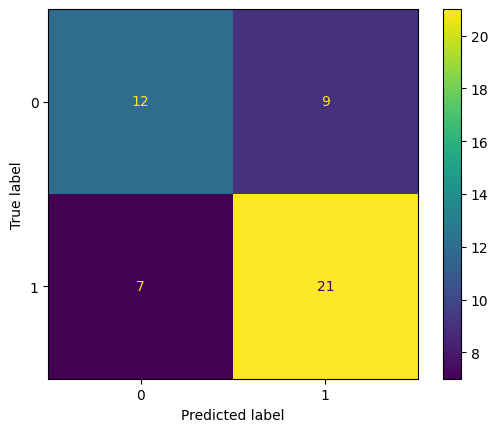

In [33]:

# Importation modèle SVM, définition des hyperparamètres et entraînement
from sklearn import svm
from sklearn import metrics

# initialisation
model_svc = svm.SVC(kernel='rbf', C=100, gamma = 0.001)  # On utilise soit rbf soit Radial Gaussian Kernel

# apprentissage
model_svc.fit(X_train_hotencoded_scaled, y_inv_train)

# score et matrice de confusion
print(f"RBF SVM score(C=10): {model_svc.score(X_test_hotencoded_scaled, y_inv_test):.3f}")
metrics.ConfusionMatrixDisplay.from_predictions(y_inv_test, model_svc.predict(X_test_hotencoded_scaled))

On recherche le modèle svm avec les meilleurs hyperparamètres pour notre porblème, et on l'évalue

0.717687074829932
SVC(C=np.float64(39.44444444444444), gamma=np.float64(0.01), kernel='sigmoid') {'C': np.float64(39.44444444444444), 'gamma': np.float64(0.01), 'kernel': 'sigmoid'}


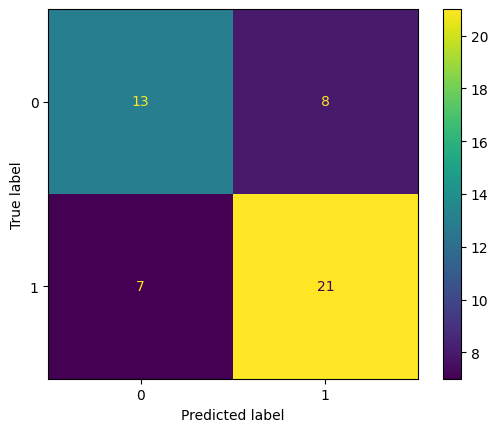

In [34]:
from sklearn.model_selection import GridSearchCV

# Dictionnaire des hyperparamètres à tester
dict_cv = {'kernel': ['rbf', 'sigmoid'],
           'C': np.linspace(35,40, num=10),
           'gamma': np.linspace(1e-2, 5, num=20)}  # Les valeurs à tester pour chaque hyperparamètre

# Initialiser GridSearchCV avec le modèle et les hyperparamètres à tester
cvsearch = GridSearchCV(svm.SVC(degree=3, coef0=0.0, shrinking=True, probability=False,
                                tol=0.001, cache_size=200, class_weight=None, verbose=False,
                                max_iter=-1, decision_function_shape='ovr', break_ties=False,
                                random_state=None), dict_cv, cv=5, scoring = 'roc_auc')  # 'cv=3' pour une validation croisée à 3 plis

# Apprentissage
cvsearch.fit(X_train_hotencoded_scaled, y_inv_train.ravel())
print(cvsearch.score(X_test_hotencoded_scaled, y_inv_test))

# Afficher le meilleur modèle trouvé, son score et sa matrice de confusion
print(cvsearch.best_estimator_, cvsearch.best_params_)
model_adaboost_svm = cvsearch.best_estimator_
metrics.ConfusionMatrixDisplay.from_predictions(y_inv_test, cvsearch.predict(X_test_hotencoded_scaled))

On tente d'améliorer les performances du meilleur modèle SVM avec du boosting

In [35]:
# On implémente du boosting pour essayer d'améliorer les performances et on utilise pour cela AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
# Créer le modèle AdaBoost avec le SVM comme classificateur de base
adaboost_svm = AdaBoostClassifier(estimator=model_adaboost_svm, n_estimators=50, learning_rate=1, algorithm='SAMME')

# Dictionnaire des hyperparamètres à tester
grid_adaboost_svm = {'n_estimators': [10,20,30,40,50]}

# Initialiser GridSearchCV avec le modèle et les hyperparamètres à tester
adasearch_svm = GridSearchCV(AdaBoostClassifier(estimator=model_adaboost_svm,
                                            learning_rate=1.0, algorithm='SAMME', random_state=None),
                                            grid_adaboost_svm, cv=5, scoring = 'roc_auc')  # 'cv=3' pour une validation croisée à 3 plis

# Apprendre avec les données d'entraînement
adasearch_svm.fit(X_train_hotencoded_scaled, y_inv_train.ravel())
print(adasearch_svm.score(X_test_hotencoded_scaled, y_inv_test))

# Afficher le meilleur modèle trouvé
print(adasearch_svm.best_estimator_, adasearch_svm.best_params_)

0.6335034013605442
AdaBoostClassifier(algorithm='SAMME',
                   estimator=SVC(C=np.float64(39.44444444444444),
                                 gamma=np.float64(0.01), kernel='sigmoid'),
                   n_estimators=10) {'n_estimators': 10}


# Multi Layer Perceptron

## 1ère méthode: données normalisées

Nous nous sommes ensuite penchés sur un modèle de classification: le MLPClassfier. Ce dernier disposant de plus de paramètres, nous avons pu expérimenter différentes choses.

Nous avons commencé par l'appliquer sur les données normalisées afin que les caractéristiques plus grandes n'aient pas plus d'impact que les autres lors de l'apprentissage.

In [36]:
from sklearn.neural_network import MLPClassifier

In [37]:
#Utilisation d'un grid_search afin de trouver les meilleurs hyperparamètres pour le modèle

param_grid_mlpc1 = {'hidden_layer_sizes': [(100,),(50,50),(70,70),(35,35),(200,),(100,100)],'alpha': [0.001,0.01,1] }


grid_search_mlpc1 = GridSearchCV(MLPClassifier(activation='relu',
                    solver='adam', batch_size='auto', learning_rate='constant',
                    learning_rate_init=0.001, power_t=0.5, max_iter=1000, tol=0.0001,
                    early_stopping=False,verbose=0),
                               param_grid=param_grid_mlpc1, cv=5, verbose=0, scoring='roc_auc')

In [38]:
grid_search_mlpc1.fit(X_train_scaled,y_inv_train.ravel())

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000, verbose=0),
             param_grid={'alpha': [0.001, 0.01, 1],
                         'hidden_layer_sizes': [(100,), (50, 50), (70, 70),
                                                (35, 35), (200,), (100, 100)]},
             scoring='roc_auc')

In [39]:
print(grid_search_mlpc1.best_params_)

{'alpha': 0.001, 'hidden_layer_sizes': (70, 70)}


In [40]:
print(f"Le meilleur score lors de l'entrainement était: {grid_search_mlpc1.best_score_}, et le score de test est {grid_search_mlpc1.score(X_test_scaled, y_inv_test.ravel())}")


Le meilleur score lors de l'entrainement était: 0.6568627450980391, et le score de test est 0.7857142857142857


Matrice de confusion sur le jeu de test


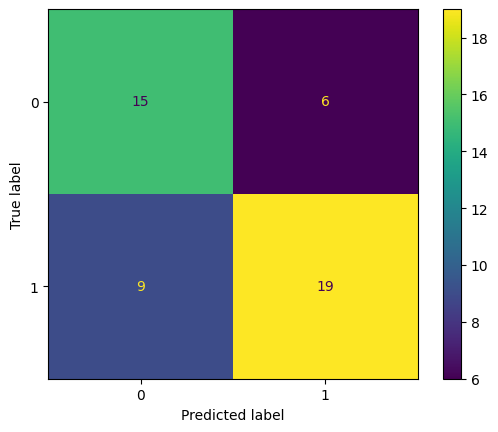

In [41]:
ConfusionMatrixDisplay.from_predictions(y_inv_test, grid_search_mlpc1.predict(X_test_scaled))
print(f"Matrice de confusion sur le jeu de test")

Ce modèle donne des performances légèrements plus faibles que le premier RF. Afin de l'améliorer, nous avons choisi de le tester sur des données OneHot encodées et normalisées.

## 2ème méthode: données normalisées et onehot encodées


In [42]:
#Utilisation d'un grid_search afin de trouver les meilleurs hyperparamètres pour le modèle

param_grid_mlpc2 = {'hidden_layer_sizes': [(100,),(50,50),(70,70),(80,80),(90,90),(70,70,10),(35,35),(200,),(150,),(150,150),(100,100)],'activation':['relu','tanh'],'alpha': [0.001,0.01,0.1,1] }


grid_search_mlpc2 = GridSearchCV(MLPClassifier(
                    solver='adam', batch_size='auto', learning_rate='constant',
                    learning_rate_init=0.001, max_iter=1000,
                    early_stopping=False, verbose=0),
                               param_grid=param_grid_mlpc2, cv=5, verbose=0, scoring='roc_auc')

In [43]:
grid_search_mlpc2.fit(X_train_hotencoded_scaled,y_inv_train.ravel())

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000, verbose=0),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.001, 0.01, 0.1, 1],
                         'hidden_layer_sizes': [(100,), (50, 50), (70, 70),
                                                (80, 80), (90, 90),
                                                (70, 70, 10), (35, 35), (200,),
                                                (150,), (150, 150),
                                                (100, 100)]},
             scoring='roc_auc')

In [44]:
print(grid_search_mlpc2.best_params_)


{'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (150, 150)}


In [45]:
print(f"Le meilleur score lors de l'entrainement était: {grid_search_mlpc2.best_score_}, et le score de test est {grid_search_mlpc2.score(X_test_hotencoded_scaled, y_inv_test.ravel())}")


Le meilleur score lors de l'entrainement était: 0.6733384262796027, et le score de test est 0.6887755102040817


Matrice de confusion sur le jeu de test


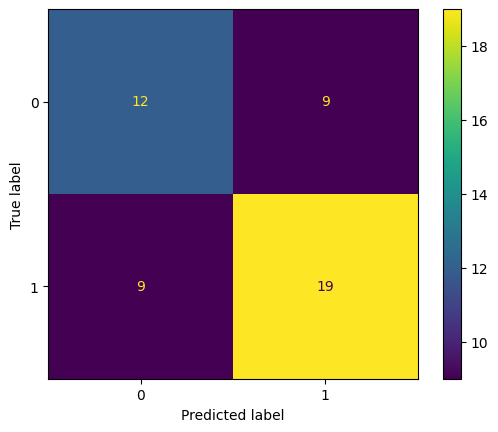

In [46]:
ConfusionMatrixDisplay.from_predictions(y_inv_test, grid_search_mlpc2.predict(X_test_hotencoded_scaled))
print(f"Matrice de confusion sur le jeu de test")

Cette fois ci nous avons encore perdue en scoring comparés au Random Forest initial. Nous avons pensé que le réseau de neurones n'avait peut être pas assez de données pour apprendre et être efficace contre le bruit. C'est pourquoi nous avons choisi pour la suite de basculer sur un modèle de Boosting, rensemblant à une méthode de random forest mais pour les réseaux de neurone.

# AdaBoost et DecisionTreeClassifier

In [47]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
#Utilisation d'un grid_search afin de trouver les meilleurs hyperparamètres pour le modèle de boosting
param_grid_adab1 = {'n_estimators': [1,2,3,45,10,20,30], 'learning_rate': [1e-5,1e-6,0.0005,0.005,0.001]}

grid_search_adab1 = GridSearchCV(AdaBoostClassifier(algorithm="SAMME"),
                               param_grid=param_grid_adab1, cv=5, verbose=0, scoring='roc_auc')

In [53]:
grid_search_adab1.fit(X_train_hotencoded_scaled,y_inv_train.ravel())

GridSearchCV(cv=5, estimator=AdaBoostClassifier(algorithm='SAMME'),
             param_grid={'learning_rate': [1e-05, 1e-06, 0.0005, 0.005, 0.001],
                         'n_estimators': [1, 2, 3, 45, 10, 20, 30]},
             scoring='roc_auc')

In [54]:
print(grid_search_adab1.best_params_)

{'learning_rate': 1e-05, 'n_estimators': 1}


In [55]:
print(f"Le meilleur score lors de l'entrainement était: {grid_search_adab1.best_score_}, et le score de test est {grid_search_adab1.score(X_test_hotencoded_scaled, y_inv_test.ravel())}")


Le meilleur score lors de l'entrainement était: 0.6660173160173161, et le score de test est 0.7321428571428572


Matrice de confusion sur le jeu d'entrainement


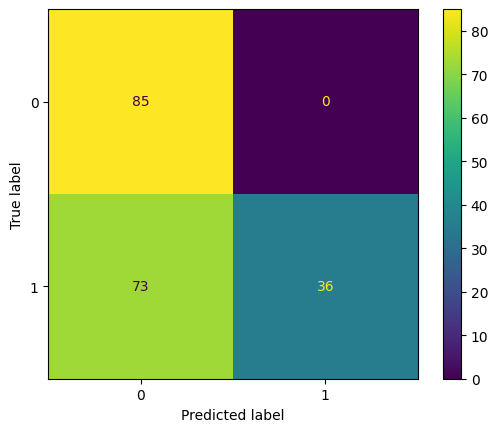

In [56]:
ConfusionMatrixDisplay.from_predictions(y_inv_train, grid_search_adab1.predict(X_train_hotencoded_scaled))
print(f"Matrice de confusion sur le jeu d'entrainement")

Matrice de confusion sur le jeu de test


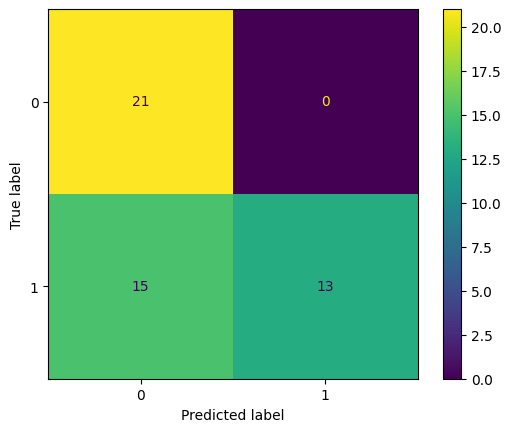

In [57]:
ConfusionMatrixDisplay.from_predictions(y_inv_test, grid_search_adab1.predict(X_test_hotencoded_scaled))
print(f"Matrice de confusion sur le jeu de test")

Les résultats fournis ont été très satisfaisants selon nous dans la mesure où tous les négatifs étaient des vrais négatifs, ce que nous cherchions à maximiser. Avec cet algorithme, chaque exemple du data set de test pour lesquels l'algorithme annonce que la chimiothérapie ne marchera pas peut être écarté du traitement sans risque important de s'être trompé.


Jusqu'à présent, c'est cette algorithme qui, à nos yeux, fournit les résultats les plus satisfaisants.

# Effet de la modalité des variables

Nous souhaitons désormais étudier l'effet de la modalité des variables

Pour rappel, ces variables appartiennent à 3 modalités différentes :
- variables cliniques : `Age`, `BMI`, `Menopausal status`, `T stage`, `N stage`
- variables histologiques : `ER Status`, `PR Status`, `Ki67 25%`, `TILs 30%`
- variables d'imagerie : `Breast Density`, `US LN Cortex`, `Intratumoral high SI on T2`, `Peritumoral Edema`, `Prepectoral Edema`, `Subcutaneous Edema`, `Multifocality`, `Maximal MR Size`, `Index Lesion MR Size`, `Size of Largest LN metastasis (mm)`.

En l'occurence, nous allons regarder l'effet de la privation des données d'imagerie, histologique, et clinique sur les performances d'un modèle de random forest.

In [58]:
# Obtenir les noms des colonnes
nom_des_variables = df_data.columns
print("Noms des variables :", nom_des_variables)

Noms des variables : Index(['Age', 'Menopausal Status', 'T Stage', 'N Stage', 'ER Status',
       'PR Status', 'Ki67 25%', 'TILs 30%', 'Breast Density', 'US LN Cortex',
       'Intratumoral high SI on T2', 'Peritumoral Edema', 'Prepectoral Edema',
       'Subcutaneous Edema', 'Multifocality', 'Maximal MR Size',
       'Index Lesion MR Size', 'Size of Largest LN metastasis (mm)'],
      dtype='object')


In [59]:
# Exemple d'indices des variables à supprimer
indices_cliniques = [0, 1, 2, 3]  # Exemple : indices des variables cliniques
indices_histologiques = [4, 5, 6, 7]  # Indices des variables histologiques
indices_imagerie = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]  # Indices des variables d'imagerie

# Supprimer toutes les variables cliniques et histologiques
indices_to_remove_1 = indices_cliniques
indices_to_remove_2 = indices_histologiques
indices_to_remove_3 = indices_imagerie
indices_to_remove_4 = indices_cliniques + indices_histologiques

In [60]:
# Supprimer les colonnes correspondantes aux variables cliniques
data_train_reduced_1 = np.delete(X_train_hotencoded, indices_to_remove_1, axis=1)
data_test_reduced_1 = np.delete(X_test_hotencoded, indices_to_remove_1, axis=1)

# Supprimer les colonnes correspondantes aux variables histologiques
data_train_reduced_2 = np.delete(X_train_hotencoded, indices_to_remove_2, axis=1)
data_test_reduced_2 = np.delete(X_test_hotencoded, indices_to_remove_2, axis=1)

# Supprimer les colonnes correspondantes aux variables d'imagerie
data_train_reduced_3 = np.delete(X_train_hotencoded, indices_to_remove_3, axis=1)
data_test_reduced_3 = np.delete(X_test_hotencoded, indices_to_remove_3, axis=1)

# Ne retenir que les variables d'imagerie
data_train_reduced_4 = np.delete(X_train_hotencoded, indices_to_remove_4, axis=1)
data_test_reduced_4 = np.delete(X_test_hotencoded, indices_to_remove_4, axis=1)

# Vérification
print("Dimensions originales : ", X_train_hotencoded.shape)
print("Dimensions réduites : ", data_train_reduced_1.shape)

print(data_train_reduced_3.shape)  # Doit afficher le même nombre de colonnes que ci-dessous
print(data_test_reduced_3.shape)  # Assurez-vous que les dimensions correspondent


Dimensions originales :  (194, 24)
Dimensions réduites :  (194, 20)
(194, 14)
(49, 14)


In [62]:
# Test du modèle sur les différents jeux de données, avec des variables tronquées ou non
model_rf_effet_variables = RandomForestClassifier(max_depth=None, n_estimators=80,
            criterion='gini', min_samples_split=2, min_samples_leaf=6, min_weight_fraction_leaf=0.0,
            max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
            random_state=42, verbose=0,class_weight=None, ccp_alpha=0.0, max_samples=None)

# Entraînement du modèle sur les trois différents jeux de données et évaluation de la performance
model_rf_effet_variables.fit(X_train_hotencoded_scaled, y_inv_train.ravel())
print(f"Performance du modèle entraîné avec toutes les variables : {model_rf_effet_variables.score(X_test_hotencoded_scaled, y_inv_test.ravel()):.3f}")

model_rf_effet_variables.fit(data_train_reduced_1, y_inv_train.ravel())
print(f"Performance du modèle entraîné sans variables cliniques : {model_rf_effet_variables.score(data_test_reduced_1, y_inv_test.ravel()):.3f}")

model_rf_effet_variables.fit(data_train_reduced_2, y_inv_train.ravel())
print(f"Performance du modèle entraîné sans variables histologiques : {model_rf_effet_variables.score(data_test_reduced_2, y_inv_test.ravel()):.3f}")

model_rf_effet_variables.fit(data_train_reduced_3, y_inv_train.ravel())
print(f"Performance du modèle entraîné sans variables d'imagerie : {model_rf_effet_variables.score(data_test_reduced_3, y_inv_test.ravel()):.3f}")

model_rf_effet_variables.fit(data_train_reduced_4, y_inv_train.ravel())
print(f"Performance du modèle entraîné uniquement avec les variables d'imagerie : {model_rf_effet_variables.score(data_test_reduced_4, y_inv_test.ravel()):.3f}")


Performance du modèle entraîné avec toutes les variables : 0.735
Performance du modèle entraîné sans variables cliniques : 0.735
Performance du modèle entraîné sans variables histologiques : 0.653
Performance du modèle entraîné sans variables d'imagerie : 0.571
Performance du modèle entraîné uniquement avec les variables d'imagerie : 0.694


Avec notre modèle précédent de Random Forest, il apparaît que la performance du modèle baisse faiblement si on retire les données cliniques, de 75% à 73,5%.
En revanche, elle diminue d'environ 10% si on retire les données histologiques, et de 20% sans les données d'imagerie. Il semble donc que ces deux dernières modalités de données soient indispensables pour construire notre modèle de prédicition.

Par ailleurs, si on ne conserve que les données d'imagerie, on abaisse la performance uniquement de 5%. Ces données d'imagerie sont par ailleurs plus nombreuses que les autres (10 variables au lieu de 4 seulement en clinique et en histologie). Le fait que la performance reste correcte peut peut-être s'expliquer par le nombre supérieure de données d'imagerie.